In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [44]:
def process_csv(input_file, output_file):
    # Read the CSV file without ignoring blank lines
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Initialize variables
    word_id = 0
    processed_data = []
    
    for line in lines:
        line = line.strip()
        if line == "":
            # Increment word_id when encountering an empty line
            word_id += 1
        else:
            # Split the line into components
            parts = line.split(',')
            if len(parts) == 4:  # Ensure the line has all expected parts
                word, x, y, time = parts
                processed_data.append([word, x, y, time, word_id])
    
    # Convert the processed data to a DataFrame
    processed_df = pd.DataFrame(processed_data, columns=['word', 'x', 'y', 'time', 'word_id'])
    
    # Save the processed DataFrame to a new CSV file
    processed_df.to_csv(output_file, index=False)

# Usage
input_file = '../data/gaze-collection-circle-a3ba97e7.txt'
output_file = '../data/collection-circle_v1.csv'
process_csv(input_file, output_file)

In [51]:
df_circle = pd.read_csv(output_file)

R = 0.891277
CENTER = (0.0, 0.424)

## Filter

In [54]:
# Filter out all the points that are inside the circle
df_circle['x'] = df_circle['x'].astype(float)
df_circle['y'] = df_circle['y'].astype(float)
df_circle['time'] = df_circle['time'].astype(float)
df_circle['distance'] = np.sqrt((df_circle['x'] - CENTER[0])**2 + (df_circle['y'] - CENTER[1])**2)

df_circle = df_circle[df_circle['distance'] > R]

In [55]:
df_circle.head()

,word,x,y,time,word_id,distance
16,ANOTHER,-0.343100,1.381394,0.405312,0,1.017016
17,ANOTHER,-0.324139,1.377763,0.429138,0,1.007338
18,ANOTHER,-0.321523,1.390080,0.448729,0,1.018178
19,ANOTHER,-0.346620,1.398574,0.468777,0,1.034379
20,ANOTHER,-0.348661,1.383083,0.489917,0,1.020492


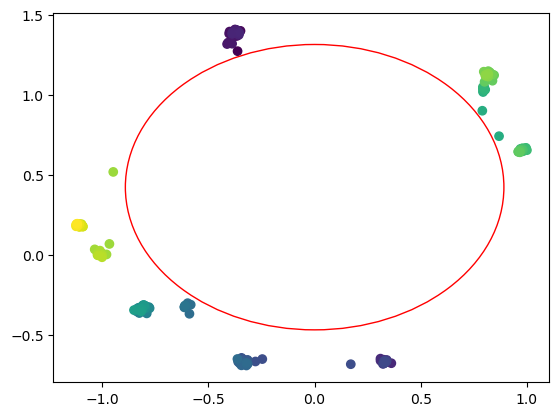

In [66]:
first_word = df_circle.groupby('word_id').get_group(1)

plt.scatter(first_word['x'], first_word['y'], c=first_word.index, cmap='viridis')

# Draw the circle with CENTER and R
circle = plt.Circle(CENTER, R, color='r', fill=False)
plt.gca().add_artist(circle) 

In [67]:
def cluster_fixations_3d(df, eps=0.1, min_samples=5):
    # Extract relevant columns for clustering (x, y, time)
    df['time'] = df['time'].astype(float)
    X = df[['x', 'y', 'time']].astype(float)
    
    # Apply DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    df['cluster'] = db.labels_

    print(f"Number of clusters: {len(set(db.labels_))}")

    return df, db

df_clustered, db = cluster_fixations_3d(first_word, eps=0.1, min_samples=5)

Number of clusters: 11


/tmp/ipykernel_13415/1520666086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'].astype(float)
/tmp/ipykernel_13415/1520666086.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = db.labels_


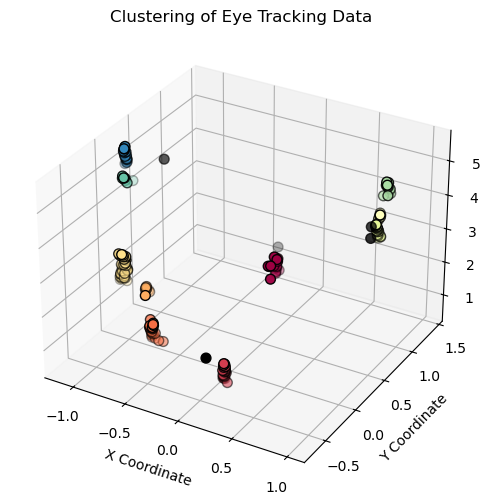

In [68]:
def visualize_3d_clusters(df, db):
    X = df[['x', 'y', 'time']].astype(float)
    
    # Plot the clusters in 3D
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = set(db.labels_)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (db.labels_ == k)
        
        xyz = X[class_member_mask]
        ax.scatter(xyz['x'], xyz['y'], xyz['time'], c=[tuple(col)], marker='o', s=50, edgecolors='k')
    
    ax.set_title('Clustering of Eye Tracking Data')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Time (s)')
    plt.savefig('3d_clusters.png')
    plt.show()

visualize_3d_clusters(df_clustered, db)

In [69]:
def filter_clusters(df, min_points=10):
    counts = df['cluster'].value_counts()
    valid_clusters = counts[counts >= min_points].index
    df_filtered = df[df['cluster'].isin(valid_clusters)]

    # Filter out cluster -1 (noise)
    df_filtered = df_filtered[df_filtered['cluster'] != -1]
    
    return df_filtered


df_filtered = filter_clusters(df_clustered, min_points=10)

len(df_filtered)

178

In [72]:
def create_keyboard(path: str, KEY_LENGTH=.27) -> dict:
    with open(path, 'r') as f:
        lines = f.readlines()
    
    keyboard = {}
    for line in lines:
        key, center = line.strip().split()

        center = center.replace('(', '').replace(')', '')

        center_x, center_y = center.split(',')
        center_x, center_y = float(center_x), float(center_y)

        keyboard[key] = (
            (center_x, center_y), # Center (x, y)
            (center_x - KEY_LENGTH/2, center_y + KEY_LENGTH/2), # Top left
            (center_x + KEY_LENGTH/2, center_y + KEY_LENGTH/2), # Top right
            (center_x + KEY_LENGTH/2, center_y - KEY_LENGTH/2), # Bottom right
            (center_x - KEY_LENGTH/2, center_y - KEY_LENGTH/2)  # Bottom left
        )
    
    return keyboard

keyboard = create_keyboard('../data/keyboard_circle.txt')

In [73]:
def find_key_centroid(df_cluster, keyboard):
    centroids = df_cluster.groupby('cluster')[['x', 'y']].mean()

    keys = []
    
    for cluster_id, centroid in centroids.iterrows():
        distances = {}
        for key, points in keyboard.items():
            center, top_left, top_right, bottom_right, bottom_left = points
            distance = np.linalg.norm(np.array(centroid) - np.array(center))
            distances[key] = distance
        
        # Print 3 smallest distances
        sorted_distances = sorted(distances.items(), key=lambda x: x[1])

        keys.append(sorted_distances[:3])

        print(f"Cluster {cluster_id}: " + ', '.join([f"{key} ({distance:.2f})" for key, distance in sorted_distances[:3]]))
    
    return keys

keys = find_key_centroid(df_filtered, keyboard)

Cluster 0: A (0.07), SWXZ (0.45), BCD (0.66)
Cluster 1: MN (0.07), JKL (0.55), O (0.64)
Cluster 2: O (0.07), PQVT (0.59), MN (0.66)
Cluster 4: PQVT (0.01), O (0.57), R (0.59)
Cluster 6: FGH (0.08), I (0.47), E (0.54)
Cluster 7: E (0.04), FGH (0.45), BCD (0.63)
Cluster 8: R (0.19), PQVT (0.39), UY (0.71)
Cluster 9: R (0.06), UY (0.55), PQVT (0.59)
